# Melanoma Detection

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [56]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

### Importing Skin Cancer Data

In [64]:
#data mounting through the google drive

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#root_path = '/content/gdrive/My Drive/UPGRAD_MLC62/Datasets/Skin_cancer_ISIC'

#data mounting through the local drive
root_path = '/Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration'


In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('**/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('**/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [8]:
#Use 80% of the images for training, and 20% for validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
#Printing all the classes present in the dataset.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height, img_width),
                                                                    label_mode='categorical',seed=123)
#all the classes of Skin Cancer
class_names = image_dataset.class_names
print(class_names)

Found 2239 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the class present in the dataset.

2024-09-18 04:54:14.697078: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


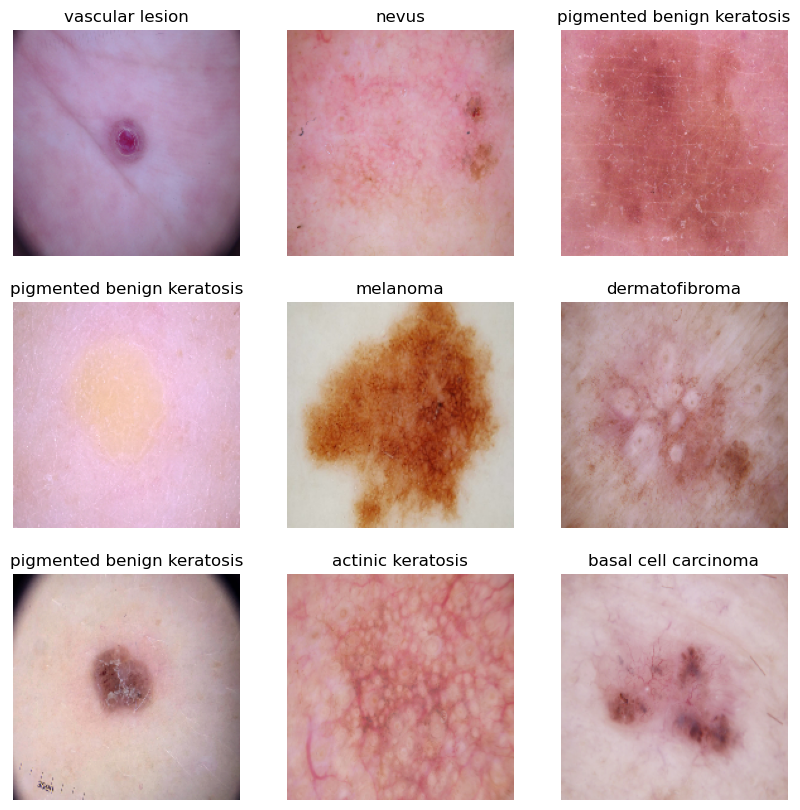

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in image_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # Get the index of the highest probability to determine the predicted class
    predicted_label = labels[i].numpy().argmax()
    plt.title(class_names[predicted_label])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Creating the initial model

In [15]:
#CNN Initial Model Architecture
model = Sequential()
#normalizing pixel values between (0,1), Since RGB channel values are in the `[0, 255]` range and is not ideal for a neural network. 
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Convolution layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#Second Convolution layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#Third Convolution layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#Flatten layers
model.add(layers.Flatten())
#Dense layers
model.add(layers.Dense(128, activation='relu'))

#Output Dense layer with softmax function
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [17]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.1978 - loss: 2.4975 - val_accuracy: 0.3669 - val_loss: 1.8201
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.3729 - loss: 1.7798 - val_accuracy: 0.4295 - val_loss: 1.5990
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.4194 - loss: 1.6199 - val_accuracy: 0.4251 - val_loss: 1.6448
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.4846 - loss: 1.4458 - val_accuracy: 0.4989 - val_loss: 1.4282
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.5342 - loss: 1.3475 - val_accuracy: 0.5280 - val_loss: 1.4377
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.5763 - loss: 1.2540 - val_accuracy: 0.5302 - val_loss: 1.5086
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.5657 - loss: 1.2168 - val_accuracy: 0.5034 - val_loss: 1.4552
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.5531 - loss: 1.2120 - val_accu

### Visualizing training results

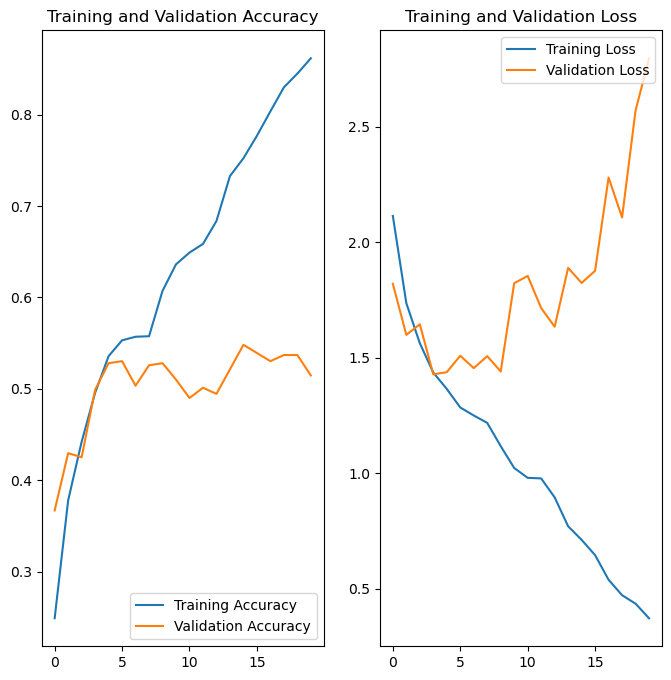

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:

- After 4-5 epochs, the accuracy of the model stopped improving for the validation data sets
- After 4-5 epochs, the loss started increasing for the validation data sets while it decreased significantly for the training sets
- The model is overfitting on the training datasets

### **Next steps:** Find the distribution of classes in the training dataset.

- **Context**: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [20]:
#Creating a dataframe to analyze the distribution
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,439
1,pigmented benign keratosis,463
2,nevus,358
3,basal cell carcinoma,377
4,actinic keratosis,115
5,squamous cell carcinoma,182
6,vascular lesion,139
7,seborrheic keratosis,78
8,dermatofibroma,96


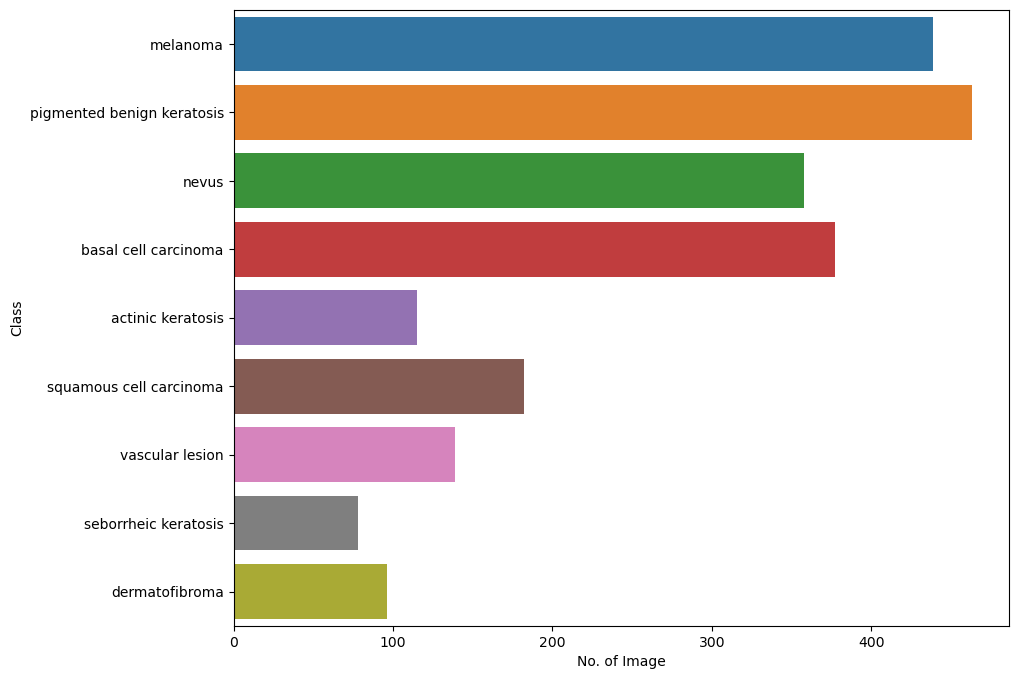

In [21]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")
plt.show()

### Findings:

-  Class seborrheic keratosis has the least number of samples - 78 nos
-  Classes like pigmented benign keratosis	& melanoma dominate the data in terms proportionate number of samples


### **Next steps:**  Rectifying the class imbalance using a python package called Augmentor

In [22]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [23]:
import Augmentor
from pathlib import Path

for i in class_names:
    # Assuming data_dir_train is a Path object
    p = Augmentor.Pipeline(data_dir_train / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Adding 500 samples per class (highest count among classes)


Initialised with 114 image(s) found.
Output directory set to /Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x346BB7790>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to /Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 95 image(s) found.
Output directory set to /Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 438 image(s) found.
Output directory set to /Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 357 image(s) found.
Output directory set to /Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0


Initialised with 462 image(s) found.
Output directory set to /Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x346C10F70>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x346C6E890>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 139 image(s) found.
Output directory set to /Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x346B7E980>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [24]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
print(path_list)

['/Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010809.jpg_d5b3976a-c2f9-4436-9fc9-786c48a53d07.jpg', '/Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010414.jpg_31247e42-90f5-47d6-8f41-2f3a2605d554.jpg', '/Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000160.jpg_8898089c-4137-440b-b578-a827e2f552f7.jpg', '/Users/rameshkrishnan/Documents/Rkn/Learning/Masters in AI/Assignments/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010401.jpg_e6254e55-a99f-46e0-997d-c19b7b

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [36]:
new_df['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Training the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [40]:
data_dir_train = pathlib.Path(root_path + '/Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Creating an improvised model

In [49]:
#CNN Model Architecture
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))#rescaling layer

#First Convolution layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#Second Convolution layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#Third Convolution layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.3))

#Flatten layers
model.add(layers.Flatten())
#Dense layers
model.add(layers.Dense(128, activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.3))

#Output Dense layer with softmax function
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model 

In [50]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


#### Training the model

In [51]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 259ms/step - accuracy: 0.2155 - loss: 2.5671 - val_accuracy: 0.4195 - val_loss: 1.7281
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - accuracy: 0.3833 - loss: 1.5971 - val_accuracy: 0.4484 - val_loss: 1.6384
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 259ms/step - accuracy: 0.4599 - loss: 1.4344 - val_accuracy: 0.4922 - val_loss: 1.5972
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.4901 - loss: 1.3295 - val_accuracy: 0.4952 - val_loss: 1.4472
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 259ms/step - accuracy: 0.5358 - loss: 1.2179 - val_accuracy: 0.5471 - val_loss: 1.3782
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.5663 - loss: 1.1451 - val_accuracy: 0.6028 - val_loss: 1.2161
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 259ms/step - accuracy: 0.6022 - loss: 1.0554 - val_accuracy: 0.5427 - val_loss: 1.2234
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 256ms/step - accuracy: 0.6274 - loss: 0

#### Visualizing the model results

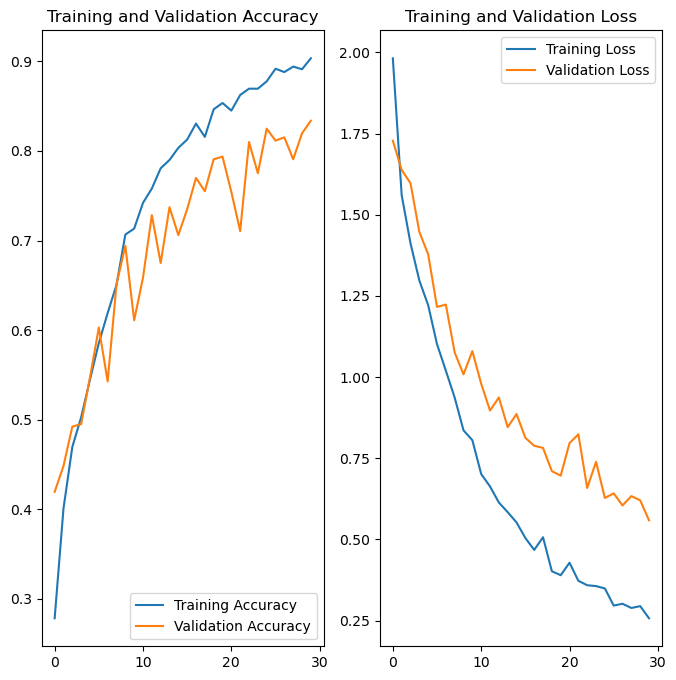

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings:



- Inorder to improve the model several measures were tested including Dropouts and Batch Normalization.
- Batch Normalization did not improve the validation accuracy (rather it slowed down the learning.
- Using Dropouts after each convolutional layer,and  before & after the flattening of layers significantly improved both the training and validation accuracy.
- The loss also followed the same path of reducing the training and validation accuracy with dropouts.

## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


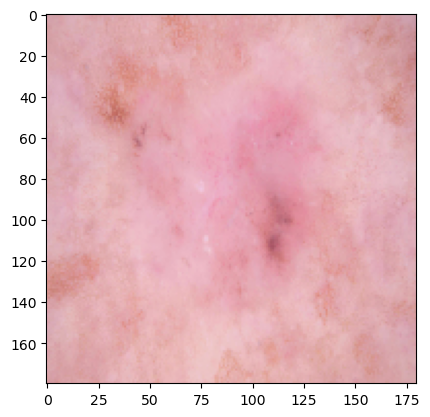

In [63]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[10],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )